 # Ignore this file 
 > This code is from about 2018, it is crap. See `Regression with MLP, LSTM, GRU.ipynb` for better code

<a href="https://colab.research.google.com/github/alik604/Notebooks/blob/master/my%20first%20LSTM%20-SPY%20pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
!pip install numpy --upgrade

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional # CuDNNLSTM
import math
from sklearn.metrics import mean_squared_error

# !pip install pandas-datareader
from pandas_datareader import data as pdr

!pip install yfinance
import yfinance as yf

You should consider upgrading via the 'c:\users\kali\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\kali\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
share = 'SPY'
dataset = yf.download(share) #, start="2017-01-01"
#dataset =data.drop(columns=['Open','High', 'Low','Adj Close','Volume'])
dataset.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,25.884184,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,26.068277,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,26.123499,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.399649,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,26.510111,531500


In [3]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-21,411.510010,416.290009,411.359985,416.070007,416.070007,66793000
2021-04-22,415.890015,416.779999,411.130005,412.269989,412.269989,97582800
2021-04-23,412.869995,418.250000,412.790009,416.739990,416.739990,73209200
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52102700
2021-04-27,417.929993,418.140015,416.299988,417.540009,417.540009,48983511


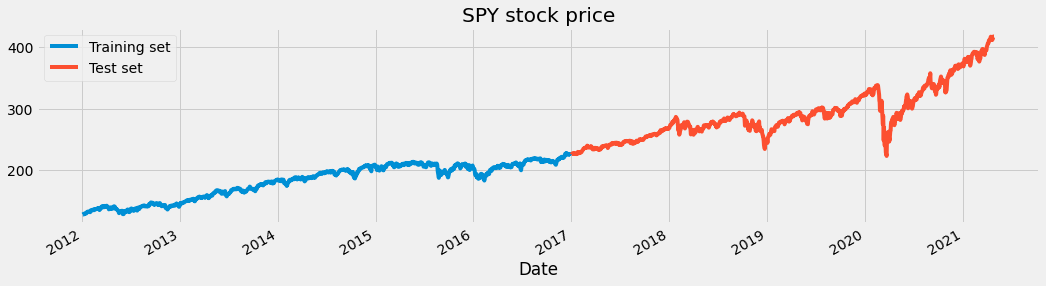

In [4]:
# Checking for missing values
training_set = dataset['2012':'2016'].iloc[:,0:1].values  #2010 or 2012
test_set = dataset['2018':].iloc[:,0:1].values
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["Close"]['2012':'2016'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title(share+' stock price')
plt.show()

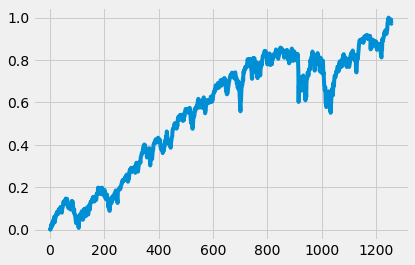

In [5]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

plt.plot(training_set_scaled)
plt.show()

In [6]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []

previous = 30

for i in range(previous,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-previous:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [7]:
# Reshaping X_train for efficient modelling

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(1228, 30, 1)

In [8]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer='adam', loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train, y_train,epochs=50,batch_size=32)

NotImplementedError: Cannot convert a symbolic Tensor (gru/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
import pandas as pd
# testing the model
dataset_total = pd.concat((dataset["High"][:'2017'],dataset["High"]['2018':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - previous:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(previous,len(inputs)):
    X_test.append(inputs[i-previous:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressorGRU.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


####################################################
print(test_set[-1],predicted_stock_price[-1])
# Visualizing the results
plt.figure(figsize=(18,5))
plt.plot(test_set[:], color='red',label='Real '+share+ ' Stock Price')
plt.plot(predicted_stock_price[:], color='blue',label='Predicted '+share+' Stock Price')
plt.title(share+' Stock Price Prediction(GRU)')
plt.xlabel('Time')
plt.ylabel(share+' Stock Price')
plt.legend()
plt.show()

In [ ]:
# Evaluating our model
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

In [ ]:
# print("prid",predicted_stock_price[len(predicted_stock_price)-1])
# print("test_set",test_set[len(test_set)-1])
# dataset.tail()

prev = predicted_stock_price[len(predicted_stock_price)-2]
current = predicted_stock_price[len(predicted_stock_price)-1]

diff =  current[0] - prev[0]

_prev = test_set[len(test_set)-2]
_current = test_set[len(test_set)-1]

_diff = _current[0] - _prev[0]


pred = predicted_stock_price
# plt.figure(figsize=(10,5))
plt.figure(figsize=(18,5))
plt.plot(test_set[-190:], color='red',label='Real SBI Stock Price')
plt.plot(predicted_stock_price[-189:], color='blue',label='Predicted SBI Stock Price')
plt.legend()
plt.show()
# print("predicted 1 day ahead",prev,current,diff)
# print("real last",_current,current,_diff)

In [ ]:
# just trying
# last_pred = predicted_stock_price
new_pred = []
scaled_t = sc.fit_transform(test_set[-31:-1])
scaled_t = np.array([scaled_t])

p = regressorGRU.predict(scaled_t)

print("last real",sc.inverse_transform(scaled_t[-1]))
print("forcast",sc.inverse_transform(p))